 Decision Tree


In [5]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, min_samples_leaf=1, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf  # Add min_samples_leaf parameter
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        if len(left_idxs) < self.min_samples_leaf or len(right_idxs) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Calculate the Information Gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def get_params(self, deep=True):
        return {
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf,
            "max_depth": self.max_depth,
            "n_features": self.n_features
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


Procesando data


In [3]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the EEG dataset
with h5py.File('./train.h5', 'r') as file:
    eeg_data = file['x'][:]  # EEG time series data
    labels = file['y'][:]     # Labels (alcoholic or control)

n_points = eeg_data.shape[2]
subject_data = eeg_data[:, 0, :n_points]  # Obtener la señal de EEG de todos los sujetos

# Convertir los datos EEG y las etiquetas a un DataFrame
time_series_data = pd.DataFrame({
    'id': np.repeat(np.arange(subject_data.shape[0]), n_points),  # 204 sujetos
    'time': np.tile(np.arange(n_points), subject_data.shape[0]),  # Tiempo para cada punto de muestra
    'value': subject_data.flatten()  # Valores de EEG
})


Usando BOSS

Accuracy:  0.7317073170731707
F1 Score:  0.56
Confusion Matrix:
 [[23  7]
 [ 4  7]]


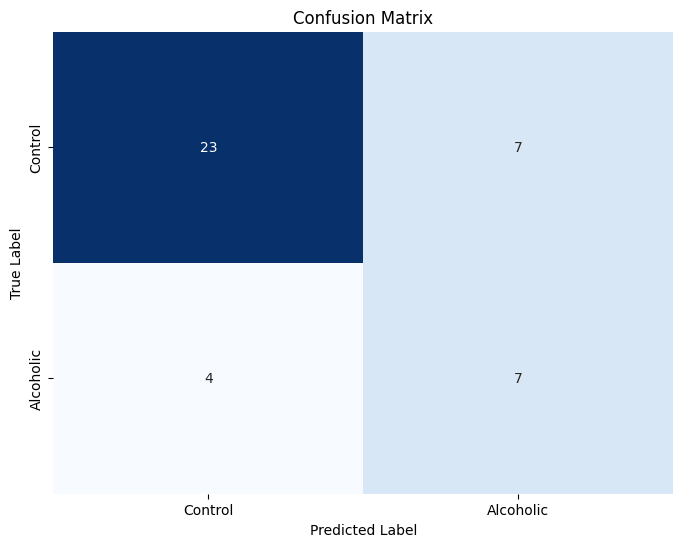

In [49]:
#!pip install pyts
from imblearn.over_sampling import SMOTE
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
import h5py
import pandas as pd
from pyts.transformation import BOSS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns

# Aplicar la transformación BOSS
n_bins = 4  # Número de bins en el modelo BOSS
boss = BOSS(n_bins=n_bins)
X_transformed = boss.fit_transform(subject_data, labels)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, labels, test_size=0.2, random_state=42)

# Aplicar PCA para reducción de dimensionalidad
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Entrenar un clasificador de árbol de decisión
dt = DecisionTree(max_depth= 10, min_samples_leaf= 2, min_samples_split= 5)
dt.fit(X_train_pca, y_train)

# Realizar predicciones
y_pred = dt.predict(X_test_pca)

# Calcular y mostrar la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Control', 'Alcoholic'], yticklabels=['Control', 'Alcoholic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Optimizando parametros


In [9]:
from imblearn.over_sampling import SMOTE
import numpy as np
import h5py
import pandas as pd
from pyts.transformation import BOSS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

# Cargar el conjunto de datos EEG
with h5py.File('./train.h5', 'r') as file:
    eeg_data = file['x'][:]  # Datos de EEG
    labels = file['y'][:]     # Etiquetas (alcohólico o control)

n_points = eeg_data.shape[2]
subject_data = eeg_data[:, 0, :n_points]

# Aplicar la transformación BOSS
n_bins = 4  # Número de bins en el modelo BOSS
boss = BOSS(n_bins=n_bins)
X_transformed = boss.fit_transform(subject_data, labels)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, labels, test_size=0.2, random_state=42)

# Aplicar PCA para reducción de dimensionalidad
n_components = 10  # Ajusta este número
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


dt = DecisionTree()

# Definir los parámetros para GridSearchCV
param_grid = {

    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5],
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Obtener el mejor clasificador
best_dt = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_dt.predict(X_test_pca)

# Calcular y mostrar la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

print(confusion_matrix(y_test, y_pred))

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros: ", grid_search.best_params_)


Accuracy:  0.7317073170731707
F1 Score:  0.56
[[23  7]
 [ 4  7]]
Mejores parámetros:  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}


Subir al Kaggle:

In [14]:
#!pip install pyts
import h5py
import numpy as np
import pandas as pd
from pyts.transformation import BOSS
from sklearn.decomposition import PCA

# Cargar el conjunto de datos de EEG (entrenamiento)
with h5py.File('./train.h5', 'r') as file:
    eeg_data = file['x'][:]  # Datos de series temporales EEG
    labels = file['y'][:]    # Etiquetas (alcohólico o control)

n_points = eeg_data.shape[2]  # Número de puntos por serie temporal
subject_data = eeg_data[:, 0, :n_points]  # Obtener la señal de EEG de todos los sujetos

# Convertir los datos EEG y las etiquetas a un DataFrame
time_series_data = pd.DataFrame({
    'id': np.repeat(np.arange(subject_data.shape[0]), n_points),  # IDs de los sujetos
    'time': np.tile(np.arange(n_points), subject_data.shape[0]),  # Tiempo para cada punto de muestra
    'value': subject_data.flatten()  # Valores de EEG
})

# Aplicar la transformación BOSS
n_bins = 4  # Número de bins en el modelo BOSS
boss = BOSS(n_bins=n_bins)
X_transformed = boss.fit_transform(subject_data, labels)

# Aplicar PCA para reducción de dimensionalidad
n_components = 10
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_transformed)

# Entrenar un clasificador de árbol de decisión
dt = DecisionTree(max_depth=10, min_samples_leaf=2, min_samples_split=5)
dt.fit(X_train_pca, labels)

# --- Predicción en el test set ---
# Cargar los datos de test
with h5py.File('./test.h5', 'r') as file:
    test_data = file['x'][:]  # Datos de test de EEG

# Obtener la señal de EEG de los datos de test
test_subject_data = test_data[:, 0, :n_points]

# Transformar los datos de test con el mismo modelo BOSS
X_test_transformed = boss.transform(test_subject_data)

# Aplicar PCA a los datos de test
X_test_pca = pca.transform(X_test_transformed)

# Realizar predicciones en el test set
y_test_pred = dt.predict(X_test_pca)

# Guardar predicciones en un archivo CSV para Kaggle
submission_df = pd.DataFrame({'ID': np.arange(1, len(y_test_pred) + 1), 'results': y_test_pred})
submission_df.to_csv('submission.csv', index=False)
